In [ ]:
import os
import torch 
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
)
from transformers import DataCollatorForLanguageModeling
from tqdm import tqdm

In [3]:
dataset = load_dataset("GingerBled/MNLP_M2_mcqa_dataset")
print(f"Dataset loaded: {dataset}")

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['id', 'dataset', 'question', 'options', 'answer'],
        num_rows: 10687
    })
})


In [4]:
# Load the model and tokenizer
model_id = "GingerBled/qwen3-0.6B-dpo-full"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    torch_dtype=torch.bfloat16,  # Changed from float16 to bfloat16 for better stability
    device_map="auto", 
    trust_remote_code=True,
    use_cache=False  # Explicitly set use_cache=False to be compatible with gradient checkpointing
)


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

In [5]:
train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = train_val["train"]
eval_dataset = train_val["test"]

print(f"Created training split with {len(train_dataset)} examples")
print(f"Created validation split with {len(eval_dataset)} examples")

Created training split with 9618 examples
Created validation split with 1069 examples


In [6]:
# ==== Define formatting & truncation parameters ====
max_length = 512  # Total allowed sequence length
truncation_mode = "keep_end"

In [7]:
def format_mcqa_as_generation(batch):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for question, options, answer in zip(batch["question"], batch["options"], batch["answer"]):
        if not isinstance(options, list):
            try:
                options = eval(options) if isinstance(options, str) else [options]
            except:
                options = [""]

        if not options:
            options = [""]

        prompt = f"Question: {question}\n\nOptions:\n"
        use_letter = len(options) > 3 or not all(opt.lower() in ["yes", "no", "maybe", "true", "false"] for opt in options)

        for idx, opt in enumerate(options):
            if use_letter:
                prompt += f"{chr(65+idx)}. {opt}\n"
            else:
                prompt += f"{opt}\n"

        # Construct the answer label text
        if use_letter and isinstance(answer, str) and len(answer) == 1 and answer.upper() in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
            label_text = f"Answer: {answer.upper()}"
        elif isinstance(answer, str) and answer in options:
            label_text = f"Answer: {answer}"
        elif isinstance(answer, int) and 0 <= answer < len(options):
            label_text = f"Answer: {options[answer]}"
        else:
            label_text = f"Answer: {options[0]}"  # fallback

        full_text = prompt + label_text

        tokenized = tokenizer(
            full_text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = tokenized["input_ids"][0]
        attention_mask = tokenized["attention_mask"][0]

        # Mask labels: don't train on prompt tokens
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        labels = input_ids.clone()
        labels[:len(prompt_ids)] = -100  # ignore prompt
        labels[attention_mask == 0] = -100  # ignore padding

        input_ids_list.append(input_ids.tolist())
        attention_mask_list.append(attention_mask.tolist())
        labels_list.append(labels.tolist())

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": labels_list
    }

In [8]:
# Tokenize datasets
tokenized_train = train_dataset.map(
    format_mcqa_as_generation,
    batched=True,
    remove_columns=train_dataset.column_names,
    load_from_cache_file=False
)

tokenized_eval = eval_dataset.map(
    format_mcqa_as_generation,
    batched=True,
    remove_columns=eval_dataset.column_names,
    load_from_cache_file=False
)

Map:   0%|          | 0/9618 [00:00<?, ? examples/s]

Map:   0%|          | 0/1069 [00:00<?, ? examples/s]

Map:   0%|          | 0/10687 [00:00<?, ? examples/s]

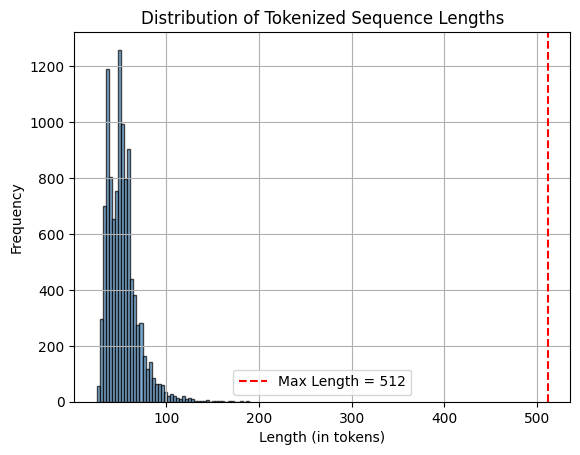

In [9]:
def get_tokenized_len(example):
    question = example["question"]
    options = example["options"]
    answer = example["answer"]

    # Format as done during training
    if not isinstance(options, list):
        try:
            options = eval(options)
        except:
            options = [""]
    if not options:
        options = [""]

    prompt = f"Question: {question}\n\nOptions:\n"
    for i, opt in enumerate(options):
        prompt += f"{chr(65+i)}. {opt}\n"
    prompt += f"Answer: {answer}"

    return {"tokenized_len": len(tokenizer(prompt)["input_ids"])}

# Apply to dataset
token_lengths = dataset["train"].map(get_tokenized_len)
lengths = token_lengths["tokenized_len"]

# Plot
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
plt.axvline(x=512, color='red', linestyle='--', label='Max Length = 512')
plt.title("Distribution of Tokenized Sequence Lengths")
plt.xlabel("Length (in tokens)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./qwen-mcqa-model",
    per_device_train_batch_size=2,             # Reduced batch size
    per_device_eval_batch_size=2,              # Reduced batch size
    gradient_accumulation_steps=8, 
    learning_rate=2e-5,
    num_train_epochs=2,
    logging_steps=100,
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=False,
    report_to="tensorboard",
    fp16=False,
    bf16=True,
    remove_unused_columns=False,
    warmup_ratio=0.1,
    gradient_checkpointing=True,
    max_grad_norm=1.0 
)

# Causal LM data collator
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=collator,
)

In [11]:
# Start the training
trainer.train()

Step,Training Loss
100,2.099200
200,1.859000
300,1.852000
400,1.845300
500,1.810500
600,1.804300
700,1.704100
800,1.733700
900,1.724500
1000,1.736600


TrainOutput(global_step=1202, training_loss=1.8005672056544044, metrics={'train_runtime': 4306.7502, 'train_samples_per_second': 4.466, 'train_steps_per_second': 0.279, 'total_flos': 2.6004183765221376e+16, 'train_loss': 1.8005672056544044, 'epoch': 1.9981285090455396})

In [12]:
# Save the model
output_dir = "./qwen-mcqa-model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Model saved to ./qwen-mcqa-model


In [13]:
# Load your fine-tuned model
model = AutoModelForCausalLM.from_pretrained("./qwen-mcqa-model")
tokenizer = AutoTokenizer.from_pretrained("./qwen-mcqa-model")

# Push to your HF repo
model.push_to_hub("GingerBled/qwen3-0.6B-mcqa")
tokenizer.push_to_hub("GingerBled/qwen3-0.6B-mcqa")

model.safetensors:   0%|          | 0.00/2.38G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/GingerBled/qwen3-0.6B-mcqa/commit/8f87ad760b6e0cbff703c21f543de3282376b7b7', commit_message='Upload tokenizer', commit_description='', oid='8f87ad760b6e0cbff703c21f543de3282376b7b7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/GingerBled/qwen3-0.6B-mcqa', endpoint='https://huggingface.co', repo_type='model', repo_id='GingerBled/qwen3-0.6B-mcqa'), pr_revision=None, pr_num=None)